### Heatmap visualisation 

##### At this point in manuscript analysis, we will:
- Load in embryo cells of interest (log normalised)
- Plot some cell state defining markers, or some other relevant/interesting markers

#### 28GB RAM used

# 1 - Import packages

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse

pd.set_option('display.max_rows', 1000000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Set up for plotting and warnings
matplotlib_axes_logger.setLevel('ERROR')
warnings.filterwarnings("ignore")
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_header()

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.23.5 scipy==1.10.1 pandas==2.0.2 scikit-learn==1.2.2 statsmodels==0.14.0 python-igraph==0.10.4 pynndescent==0.5.10


# 2 - Define paths and configs

In [2]:
# define date
date = '20240808'

# define ouput file paths
outputs_resources = '/lustre/scratch126/cellgen/team298/sw33/meninges/resources/heatmaps/' # i will save excels, etc, here
outputs_figs = '/lustre/scratch126/cellgen/team298/sw33/meninges/figures/heatmaps/' # i will save output figures here
sc.settings.figdir = outputs_figs # just making sure scanpy umaps, etc, are saved alongside the rest of my figs

# define title for plot
heatmap_title = "meningesMS_combined_ys_men_fbm_Bcell_markers"

# define input file paths
adata_path = ["/lustre/scratch126/cellgen/team298/ar32/YS_main_data_remake_mtx_barcodes_features/individual_outs", # obj1 - yolk sac               
              "/lustre/scratch126/cellgen/team298/sw33/bone_marrow/data/scRNAseq_E-MTAB-9389/",                    # obj2 - fetal bone marrow
              "/lustre/scratch126/cellgen/team298/sw33/meninges/data/Recombined3Clean2_IMM_Lymphoid_B.h5ad"]       # obj3 - meninges

# naming the metadata categories for each object which hold the donor, age, and celltype metadata respectively
meta_donor_age_celltype = {1: ['fetal.ids', "stage",  'LVL3'],                                                     # obj1 - yolk sac
                           2: ['fetal.id', "age",  'cell.labels'],                                                 # obj2 - fetal bone marrow
                           3: ["Donor", "Agepool", "Subclass"]}                                                    # obj3 - meninges
    
# define the subset of the data we will subset to. if no subsetting is needed, just set subsetting_required = False, and subsetting_metadata_col/cats to None
subsetting_required = True, True, False 
subsetting_metadata_col = {1: ['LVL3'],                                                                            # obj1 - yolk sac 
                           2: ['cell.labels'],                                                                     # obj2 - fetal bone marrow
                           3: []}                                                                                  # obj3 - meninges                  

subsetting_metadata_cats = {1: ['LYMPHOID B LIN'],                                                                 # obj1 - yolk sac
                            2: ['HSC/MPP', 'LMPP', 'ELP', 'pre pro B progenitor', 'pro B progenitor',              # obj2 - fetal bone marrow            
                                'pre B progenitor', 'immature B cell', 'naive B cell'], 
                            3: []}                                                                                 # obj3 - meninges

# if we are merging 2x adata.obs columns for groupings in dotplot, please define these here 
merge_cols = True
merge_col_names = ['dataset', 'celltype']
merged_col_name = 'dataset_celltype'

# define ordered categories for the dotplot plotting. these are required
plotting_metadata_col = merged_col_name                              
plotting_metadata_cats = ['fbm_HSC/MPP', 'fbm_LMPP', 'fbm_ELP',
                          
                         'ys_LYMPHOID B LIN',   
                         
                         'men_B cell & Plasma cell', 
                          
                         'fbm_pre pro B progenitor', 'fbm_pro B progenitor',                       
                         'fbm_pre B progenitor', 'fbm_immature B cell', 'fbm_naive B cell'] 

# give gene dictionary and vmax for dotplots
gene_dict = {
# here are some B lineage markers from fetal bone marrow - ExtFig4E - https://www.nature.com/articles/s41586-021-03929-x/figures/7
    "HSPCs-ELP-preproB-proB": ['CD34', 'SPINK2', 'MLLT3'], 
    "prepropB": ['IL7R', 'CDC45', 'DHFR', 'UHRF1'], 
    "proB": ['DNTT'], #'VPREB1',
    "preB": ['IDH2'], 
    "immature B": ['CD19', 'SPIB', 'IGHD', 'CD40', 'FCER2'], #IGHM
    "naive B": ["MS4A1"]
}

vmax_setting=2

# 3a - Import data (1st object - yolk sac)

#### Input yolk sac data files were downloaded from public accessions, manually renamed, and read into anndata format using "sc.read_10x_mtx" and pd.read_csv:
- counts - https://www.ebi.ac.uk/biostudies/files/E-MTAB-10552/YS_10x_counts.mtx.gz (renamed to: matrix.mtx.gz)
- genes - https://www.ebi.ac.uk/biostudies/files/E-MTAB-10552/YS_10x_genes.tsv.gz (renamed to: features.tsv.gz)
- barcodes - https://www.ebi.ac.uk/biostudies/files/E-MTAB-10552/YS_10x_barcodes_and_metadata.tsv.gz (renamed to: barcodes.tsv.gz)
- metadata - https://www.science.org/doi/suppl/10.1126/science.add7564/suppl_file/science.add7564_data_s1_to_s33.zip (unzip folder for: 'Table_3_YS_scRNAseq_metadata.xlsx' file, reformatted/renamed to: metadata.csv). This will also be made available on E-MTAB-10552 as: metadata.csv

In [3]:
# read in public data files for matrix, barcodes, and features -> save to anndata object
adata = sc.read_10x_mtx(adata_path[0]) 
# read in public data files for metadata -> save to anndata object
metadata = pd.read_csv(adata_path[0] + '/metadata.csv', delimiter=",", index_col=0, header=0)  
adata.obs = metadata

In [4]:
# check that public data is indeed raw
adata.X
print(adata.X.min())
print(adata.X.max())
test=adata.X[-10:-1, -10:-1]
print(test.toarray())

0.0
31635.0
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 3. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 3. 0. 0. 0. 0. 0.]
 [0. 0. 1. 5. 0. 0. 0. 0. 0.]]


In [5]:
# have a look at data object
print(adata)
print(adata.shape)
print(adata.obs[:3])
print(adata.var[:3])

AnnData object with n_obs × n_vars = 169494 × 46741
    obs: 'component', 'stage', 'sex', 'sort.ids', 'fetal.ids', 'orig.dataset', 'sequencing.type', 'lanes', 'LVL1', 'LVL2', 'LVL3', 'scrublet_cluster_score'
    var: 'gene_ids', 'feature_types'
(169494, 46741)
                                component stage   sex sort.ids  fetal.ids                    orig.dataset sequencing.type      lanes        LVL1         LVL2                    LVL3  scrublet_cluster_score
Wang_et_al_AAACCTGAGACCTTTG_1-0  Membrane  CS10  Male    Total  Wang_CS10  Wang_et_al_Cell_Stem Cell_2021             NaN  Wang_CS10      STROMA  ENDOTHELIUM  ENDOTHELIUM_SINUSOIDAL                0.042385
Wang_et_al_AAACCTGCACTTAAGC_1-0  Membrane  CS10  Male    Total  Wang_CS10  Wang_et_al_Cell_Stem Cell_2021             NaN  Wang_CS10  PROGENITOR         HSPC            EARLY_HSPC_1                0.058638
Wang_et_al_AAACCTGGTAACGACG_1-0  Membrane  CS10  Male    Total  Wang_CS10  Wang_et_al_Cell_Stem Cell_2021             NaN

In [6]:
# have a look at number of cells
cell_numbers = adata.obs.groupby(meta_donor_age_celltype[1][:2]).apply(len)
cell_numbers

fetal.ids  stage
F138       CS17     31680
F32        CS22      1001
F35        CS23      1383
F37        CS14     10729
F61        CS18     45945
F79        CS18     40585
F80        CS15     21246
Wang_CS10  CS10      3615
Wang_CS11  CS11      7054
mikola_1   CS14      6256
dtype: int64

In [7]:
# have a look at number of cells
cell_numbers = adata.obs.groupby(meta_donor_age_celltype[1][2]).apply(len)
cell_numbers

LVL3
CMP                                    25
DC2_CYCLING                            81
DEF_HSPC_1                            241
DEF_HSPC_2                            387
EARLY_ERYTHROID                       699
EARLY_HSPC_1                         1880
EARLY_HSPC_2                          560
ELP                                   605
ENDODERM                             7656
ENDOTHELIUM_AEC                      1707
ENDOTHELIUM_PROLIF_AEC                181
ENDOTHELIUM_PROLIF_SINUSOIDAL_EC     1219
ENDOTHELIUM_SINUSOIDAL               1772
ENDOTHELIUM_VWF                      1620
EOSINOPHIL_BASOPHIL                    93
EO_BASO_MAST_PRECURSOR                 56
ERYTHROID                           61327
FIBROBLAST                          28730
HE                                    314
ILC_PRECURSOR                         185
IMMATURE_ENDOTHELIUM                 1486
LMPP                                  169
LYMPHOID B LIN                        152
MAC DC2                      

In [8]:
# have a look at number of cells
cell_numbers = adata.obs.groupby(meta_donor_age_celltype[1]).apply(len)
cell_numbers

fetal.ids  stage  LVL3                            
F138       CS17   CMP                                     1
                  DC2_CYCLING                             2
                  DEF_HSPC_1                              9
                  DEF_HSPC_2                             34
                  EARLY_ERYTHROID                         9
                  EARLY_HSPC_1                           20
                  EARLY_HSPC_2                            3
                  ELP                                    54
                  ENDODERM                             3238
                  ENDOTHELIUM_AEC                       396
                  ENDOTHELIUM_PROLIF_AEC                 77
                  ENDOTHELIUM_PROLIF_SINUSOIDAL_EC      168
                  ENDOTHELIUM_SINUSOIDAL                173
                  ENDOTHELIUM_VWF                       246
                  EO_BASO_MAST_PRECURSOR                  3
                  ERYTHROID                      

# 3b - Subset the data (1st object - yolk sac)

In [9]:
if subsetting_required[0] == True:
    adata = adata[adata.obs[subsetting_metadata_col[1][0]].isin(subsetting_metadata_cats[1])].copy()

In [10]:
# have a look at data object
print(adata)
print(adata.shape)
print(adata.obs[:3])
print(adata.var[:3])

AnnData object with n_obs × n_vars = 152 × 46741
    obs: 'component', 'stage', 'sex', 'sort.ids', 'fetal.ids', 'orig.dataset', 'sequencing.type', 'lanes', 'LVL1', 'LVL2', 'LVL3', 'scrublet_cluster_score'
    var: 'gene_ids', 'feature_types'
(152, 46741)
                                                   component stage     sex sort.ids  fetal.ids                    orig.dataset sequencing.type           lanes      LVL1    LVL2            LVL3  scrublet_cluster_score
Wang_et_al_TTGTAGGTCCTAGAAC_1-0                     Membrane  CS10    Male    Total  Wang_CS10  Wang_et_al_Cell_Stem Cell_2021             NaN       Wang_CS10  LYMPHOID  B_CELL  LYMPHOID B LIN                0.081227
Wang_et_al_CGCTATCAGTGGTCCC_2-0                     Membrane  CS11  Female    Total  Wang_CS11  Wang_et_al_Cell_Stem Cell_2021             NaN       Wang_CS11  LYMPHOID  B_CELL  LYMPHOID B LIN                0.081173
F32_Yolksac_Total_FCAImmP7316900_GAACATCCACAAGC...  Contents  CS22  Female    Total        F32

In [11]:
# have a look at number of cells
cell_numbers = adata.obs.groupby(meta_donor_age_celltype[1][:2]).apply(len)
cell_numbers

fetal.ids  stage
F138       CS17      8
F32        CS22      1
F35        CS23      1
F37        CS14     15
F61        CS18     32
F79        CS18     35
F80        CS15     45
Wang_CS10  CS10      1
Wang_CS11  CS11      1
mikola_1   CS14     13
dtype: int64

In [12]:
# have a look at number of cells
cell_numbers = adata.obs.groupby(meta_donor_age_celltype[1][2]).apply(len)
cell_numbers

LVL3
LYMPHOID B LIN    152
dtype: int64

In [13]:
# have a look at number of cells
cell_numbers = adata.obs.groupby(meta_donor_age_celltype[1]).apply(len)
cell_numbers

fetal.ids  stage  LVL3          
F138       CS17   LYMPHOID B LIN     8
F32        CS22   LYMPHOID B LIN     1
F35        CS23   LYMPHOID B LIN     1
F37        CS14   LYMPHOID B LIN    15
F61        CS18   LYMPHOID B LIN    32
F79        CS18   LYMPHOID B LIN    35
F80        CS15   LYMPHOID B LIN    45
Wang_CS10  CS10   LYMPHOID B LIN     1
Wang_CS11  CS11   LYMPHOID B LIN     1
mikola_1   CS14   LYMPHOID B LIN    13
dtype: int64

In [14]:
adata_1=adata.copy()
del adata

In [15]:
adata_1.obs["sample"] = adata_1.obs[meta_donor_age_celltype[1][0]]
adata_1.obs["age"] = adata_1.obs[meta_donor_age_celltype[1][1]]
adata_1.obs["celltype"] = adata_1.obs[meta_donor_age_celltype[1][2]]

# 4a - Import data (2nd object - fetal bone marrow)

#### Input fetal bone marrow data were downloaded from public accessions, manually renamed, and read into anndata format using "sc.read_csv" and "pd.read_csv":
- counts - https://www.ebi.ac.uk/biostudies/files/E-MTAB-9389/fbm_tot_gex_20201104.csv
- metadata - https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-021-03929-x/MediaObjects/41586_2021_3929_MOESM4_ESM.xlsx from https://www.nature.com/articles/s41586-021-03929-x#Sec31 (xlsx sheet for Supplementary Table 8 was saved as csv, and filename '41586_2021_3929_MOESM4_ESM' appended with 'STable8.csv')

In [16]:
# read in public data files for matrix, barcodes, and features -> save to anndata object
adata = sc.read_csv(adata_path[1]+"fbm_tot_gex_20201104.csv", delimiter="\t", dtype="float32", first_column_names=True)
# this transpose line is only required for this FBM dataset
adata = adata.transpose()
# add in cell type information from supplementary table 8 - https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-021-03929-x/MediaObjects/41586_2021_3929_MOESM4_ESM.xlsx
metadata=pd.read_csv(adata_path[1]+"41586_2021_3929_MOESM4_ESM_STable8.csv", delimiter=",", index_col=0)
adata.obs = metadata

In [17]:
# these entire codeblock's metadata mappings are only required for this FBM dataset
# copy sample information across from information within barcode 
adata.obs['fetal.id'] = adata.obs.index.astype('str')
# the first 8x samples are codified at beginning of barcode with 'F-' ['F21', 'F29', 'F30', 'F38', 'F41', 'F45', 'F51', 'F50', 'SB19PCW']
adata.obs['fetal.id'] = adata.obs['fetal.id'].str.split('_', n=1, expand=True)[0]         
# the 9th and final sample SB19PCW is codified at end of barcode with 'WSSS-1'
adata.obs.loc[adata.obs['fetal.id'].str.contains('WSSS'), 'fetal.id'] = 'SB19PCW'
# add age information in using fetal.id>age mapping inferred from supp table 1 - https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-021-03929-x/MediaObjects/41586_2021_3929_MOESM4_ESM.xlsx
adata.obs['age'] = adata.obs['fetal.id'].replace(['F21', 'F29', 'F30', 'F38', 'F41', 'F45', 'F51', 'F50', 'SB19PCW'], 
                                                 ['16', '17', '14', '12', '16', '13', '15', '15', '19'])

In [18]:
# check that public data is indeed raw
adata.X
print(adata.X.min())
print(adata.X.max())
test=adata.X[-10:-1, -10:-1]
print(test)
#print(test.toarray())

0.0
18984.0
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [19]:
# have a look at data object
print(adata)
print(adata.shape)
print(adata.obs[:3])
print(adata.var[:3])

AnnData object with n_obs × n_vars = 103228 × 33712
    obs: 'cell.labels', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'fetal.id', 'age'
(103228, 33712)
                                                             cell.labels  Unnamed: 2  Unnamed: 3  Unnamed: 4  Unnamed: 5 fetal.id age
barcode                                                                                                                              
F21_boneMarrow_CD45+_FCAImmP7179367_3prime_AAAC...       early erythroid         NaN         NaN         NaN         NaN      F21  16
F21_boneMarrow_CD45+_FCAImmP7179367_3prime_AACT...  erythroid macrophage         NaN         NaN         NaN         NaN      F21  16
F21_boneMarrow_CD45+_FCAImmP7179367_3prime_AACT...            neutrophil         NaN         NaN         NaN         NaN      F21  16
Empty DataFrame
Columns: []
Index: [RP11-34P13.3, RP11-34P13.7, RP11-34P13.8]


In [20]:
# have a look at number of cells
cell_numbers = adata.obs.groupby(meta_donor_age_celltype[2][:2]).apply(len)
cell_numbers

fetal.id  age
F21       16      3142
F29       17      8161
F30       14     10412
F38       12      3115
F41       16      7907
F45       13      6602
F50       15     15762
F51       15     28801
SB19PCW   19     19326
dtype: int64

In [21]:
# have a look at number of cells
cell_numbers = adata.obs.groupby(meta_donor_age_celltype[2][2]).apply(len)
cell_numbers

cell.labels
CD14 monocyte               8763
CD4 T cell                   327
CD56 bright NK               449
CD8 T cell                   171
CMP                          425
DC precursor                 201
DC1                           50
DC2                          598
DC3                          705
ELP                         1357
GMP                         1281
HSC/MPP                       92
ILC precursor                 67
LMPP                          34
MEMP                          16
MEP                          269
MK                          1000
MOP                         3838
MPP myeloid                   92
NK T cell                    111
NK progenitor                 26
Treg                          62
adipo-CAR                    353
arteriolar fibroblast         83
basophil                     139
chondrocyte                   80
early MK                    1624
early erythroid             7474
early osteoblast             280
endosteal fibroblast          5

In [22]:
# have a look at number of cells
cell_numbers = adata.obs.groupby(meta_donor_age_celltype[2]).apply(len)
cell_numbers

fetal.id  age  cell.labels            
F21       16   CD14 monocyte               217
               CD4 T cell                   12
               CD56 bright NK                6
               CD8 T cell                   13
               CMP                          19
               DC precursor                 13
               DC1                           3
               DC2                          24
               DC3                          33
               ELP                          74
               GMP                          58
               HSC/MPP                      10
               ILC precursor                 4
               LMPP                          2
               MEMP                          1
               MEP                          34
               MK                           89
               MOP                         132
               MPP myeloid                   2
               NK T cell                     4
               NK pro

# 4b - Subset the data (2nd object - fetal bone marrow)

In [23]:
if subsetting_required[1] == True:
    adata = adata[adata.obs[subsetting_metadata_col[2][0]].isin(subsetting_metadata_cats[2])].copy()

In [24]:
# have a look at data object
print(adata)
print(adata.shape)
print(adata.obs[:3])
print(adata.var[:3])

AnnData object with n_obs × n_vars = 30066 × 33712
    obs: 'cell.labels', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'fetal.id', 'age'
(30066, 33712)
                                                         cell.labels  Unnamed: 2  Unnamed: 3  Unnamed: 4  Unnamed: 5 fetal.id age
barcode                                                                                                                          
F21_boneMarrow_CD45+_FCAImmP7179367_3prime_ACAT...               ELP         NaN         NaN         NaN         NaN      F21  16
F21_boneMarrow_CD45+_FCAImmP7179367_3prime_ACCC...  pre B progenitor         NaN         NaN         NaN         NaN      F21  16
F21_boneMarrow_CD45+_FCAImmP7179367_3prime_ACTA...  pre B progenitor         NaN         NaN         NaN         NaN      F21  16
Empty DataFrame
Columns: []
Index: [RP11-34P13.3, RP11-34P13.7, RP11-34P13.8]


In [25]:
# have a look at number of cells
cell_numbers = adata.obs.groupby(meta_donor_age_celltype[2][:2]).apply(len)
cell_numbers

fetal.id  age
F21       16      1171
F29       17      3750
F30       14      2671
F38       12       628
F41       16      1523
F45       13      1309
F50       15      2586
F51       15      6054
SB19PCW   19     10374
dtype: int64

In [26]:
# have a look at number of cells
cell_numbers = adata.obs.groupby(meta_donor_age_celltype[2][2]).apply(len)
cell_numbers

cell.labels
ELP                      1357
HSC/MPP                    92
LMPP                       34
immature B cell          1988
naive B cell             1411
pre B progenitor        14229
pre pro B progenitor     5427
pro B progenitor         5528
dtype: int64

In [27]:
# have a look at number of cells
cell_numbers = adata.obs.groupby(meta_donor_age_celltype[2]).apply(len)
cell_numbers

fetal.id  age  cell.labels         
F21       16   ELP                       74
               HSC/MPP                   10
               LMPP                       2
               immature B cell            5
               naive B cell              34
               pre B progenitor         597
               pre pro B progenitor     383
               pro B progenitor          66
F29       17   ELP                      198
               HSC/MPP                   15
               LMPP                       5
               immature B cell           26
               naive B cell             194
               pre B progenitor        2481
               pre pro B progenitor     717
               pro B progenitor         114
F30       14   ELP                      282
               HSC/MPP                   12
               LMPP                       3
               immature B cell           14
               naive B cell              55
               pre B progenitor        1

In [28]:
adata_2=adata.copy()
del adata

In [29]:
adata_2.obs["sample"] = adata_2.obs[meta_donor_age_celltype[2][0]]
adata_2.obs["age"] = adata_2.obs[meta_donor_age_celltype[2][1]]
adata_2.obs["celltype"] = adata_2.obs[meta_donor_age_celltype[2][2]]

# 5a - Import data (3rd object - meninges)

#### Input meninges data were downloaded from public accessions, manually renamed, and read into anndata format using "sc.read_csv" and "pd.read_csv":
- counts - https://www.ebi.ac.uk/biostudies/files/E-MTAB-9389/fbm_tot_gex_20201104.csv
- metadata - https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-021-03929-x/MediaObjects/41586_2021_3929_MOESM4_ESM.xlsx from https://www.nature.com/articles/s41586-021-03929-x#Sec31 (xlsx sheet for Supplementary Table 8 was saved as csv, and filename '41586_2021_3929_MOESM4_ESM' appended with 'STable8.csv')

In [30]:
# read in public data files for matrix, barcodes, and features -> save to anndata object
adata = sc.read(adata_path[2])

In [31]:
# this codeblock is only needed for this meneinges data to format the adata.var slot
adata.var['Accession']=adata.var.index
adata.var_names=adata.var['Gene'].astype(str)
print(adata.shape)
adata.var[:3]
adata.var_names_make_unique()
print(adata.shape)

(26, 33538)
(26, 33538)


In [32]:
# check that public data is indeed raw
adata.X
print(adata.X.min())
print(adata.X.max())
test=adata.X[-10:-1, -10:-1]
#print(test)
print(test.toarray())

0.0
584.0
[[1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 2. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]]


In [33]:
# have a look at data object
print(adata)
print(adata.shape)
print(adata.obs[:3])
print(adata.var[:3])

AnnData object with n_obs × n_vars = 26 × 33538
    obs: 'Age', 'Agepool', 'Agetext', 'Ageunit', 'All_fc_analysis_id', 'Analysis', 'Cellconc', 'Cellcycle', 'Cellcycle_g1', 'Cellcycle_g2m', 'Cellcycle_s', 'Cellcyclescore', 'Chemistry', 'Classann', 'Clusters', 'Clusterscollected', 'Clustertext', 'Cmobarcodes', 'Comment', 'Config', 'Creationdate_cells', 'Datecaptured', 'Donor', 'Doubletfinderflag', 'Doubletfinderscore', 'Editat', 'Editby', 'Id', 'Iscycling', 'Label', 'Meanage', 'Meantotalumi', 'Method', 'Mt_ratio', 'Name', 'Neuronprop', 'Newclusters', 'Ngenes', 'Numpooledanimals', 'Oldclusters', 'Oldclustersrecomb2', 'Ordering', 'Originalsubset', 'Outliers', 'Passedqc', 'Passedqc_mt_ratio', 'Passedqc_totalumi', 'Passedqc_umipergene', 'Passedqc_unsplicedratio', 'Plugdate', 'Project', 'Radius', 'Recombined3clean2clusters', 'Roi', 'Sampleid', 'Sampleok', 'Sex', 'Shortname', 'Souporcell', 'Species', 'Split', 'Strain', 'Subclass', 'Subset', 'Superclass', 'Targetnumcells', 'Tissue', 'Tissueclas

In [34]:
# have a look at number of cells
cell_numbers = adata.obs.groupby(meta_donor_age_celltype[3][:2]).apply(len)
cell_numbers

Donor    Agepool
BRC2218  6          2
BRC2226  8          1
BRC2227  7          1
BRC2243  6          1
BRC2301  10         1
XDD385   13         9
XDD399   7          1
XDD400   5          9
XHU364   7          1
dtype: int64

In [35]:
# have a look at number of cells
cell_numbers = adata.obs.groupby(meta_donor_age_celltype[3][2]).apply(len)
cell_numbers

Subclass
B cell & Plasma cell    26
dtype: int64

In [36]:
# have a look at number of cells
cell_numbers = adata.obs.groupby(meta_donor_age_celltype[3]).apply(len)
cell_numbers

Donor    Agepool  Subclass            
BRC2218  6        B cell & Plasma cell    2
BRC2226  8        B cell & Plasma cell    1
BRC2227  7        B cell & Plasma cell    1
BRC2243  6        B cell & Plasma cell    1
BRC2301  10       B cell & Plasma cell    1
XDD385   13       B cell & Plasma cell    9
XDD399   7        B cell & Plasma cell    1
XDD400   5        B cell & Plasma cell    9
XHU364   7        B cell & Plasma cell    1
dtype: int64

# 5b - Subset the data (3rd object - meninges)

In [37]:
if subsetting_required[2] == True:
    adata = adata[adata.obs[subsetting_metadata_col[3][0]].isin(subsetting_metadata_cats[3])].copy()

In [38]:
# have a look at data object
print(adata)
print(adata.shape)
print(adata.obs[:3])
print(adata.var[:3])

AnnData object with n_obs × n_vars = 26 × 33538
    obs: 'Age', 'Agepool', 'Agetext', 'Ageunit', 'All_fc_analysis_id', 'Analysis', 'Cellconc', 'Cellcycle', 'Cellcycle_g1', 'Cellcycle_g2m', 'Cellcycle_s', 'Cellcyclescore', 'Chemistry', 'Classann', 'Clusters', 'Clusterscollected', 'Clustertext', 'Cmobarcodes', 'Comment', 'Config', 'Creationdate_cells', 'Datecaptured', 'Donor', 'Doubletfinderflag', 'Doubletfinderscore', 'Editat', 'Editby', 'Id', 'Iscycling', 'Label', 'Meanage', 'Meantotalumi', 'Method', 'Mt_ratio', 'Name', 'Neuronprop', 'Newclusters', 'Ngenes', 'Numpooledanimals', 'Oldclusters', 'Oldclustersrecomb2', 'Ordering', 'Originalsubset', 'Outliers', 'Passedqc', 'Passedqc_mt_ratio', 'Passedqc_totalumi', 'Passedqc_umipergene', 'Passedqc_unsplicedratio', 'Plugdate', 'Project', 'Radius', 'Recombined3clean2clusters', 'Roi', 'Sampleid', 'Sampleok', 'Sex', 'Shortname', 'Souporcell', 'Species', 'Split', 'Strain', 'Subclass', 'Subset', 'Superclass', 'Targetnumcells', 'Tissue', 'Tissueclas

In [39]:
# have a look at number of cells
cell_numbers = adata.obs.groupby(meta_donor_age_celltype[3][:2]).apply(len)
cell_numbers

Donor    Agepool
BRC2218  6          2
BRC2226  8          1
BRC2227  7          1
BRC2243  6          1
BRC2301  10         1
XDD385   13         9
XDD399   7          1
XDD400   5          9
XHU364   7          1
dtype: int64

In [40]:
# have a look at number of cells
cell_numbers = adata.obs.groupby(meta_donor_age_celltype[3][2]).apply(len)
cell_numbers

Subclass
B cell & Plasma cell    26
dtype: int64

In [41]:
# have a look at number of cells
cell_numbers = adata.obs.groupby(meta_donor_age_celltype[3]).apply(len)
cell_numbers

Donor    Agepool  Subclass            
BRC2218  6        B cell & Plasma cell    2
BRC2226  8        B cell & Plasma cell    1
BRC2227  7        B cell & Plasma cell    1
BRC2243  6        B cell & Plasma cell    1
BRC2301  10       B cell & Plasma cell    1
XDD385   13       B cell & Plasma cell    9
XDD399   7        B cell & Plasma cell    1
XDD400   5        B cell & Plasma cell    9
XHU364   7        B cell & Plasma cell    1
dtype: int64

In [42]:
adata_3=adata.copy()
del adata

In [43]:
adata_3.obs["sample"] = adata_3.obs[meta_donor_age_celltype[3][0]]
adata_3.obs["age"] = adata_3.obs[meta_donor_age_celltype[3][1]]
adata_3.obs["celltype"] = adata_3.obs[meta_donor_age_celltype[3][2]]

# 6 - Merge objects 

In [44]:
# have a look at data object - 1st
print(adata_1)
print(adata_1.shape)
print(adata_1.obs[:3])
print(adata_1.var[:3])
# have a look at number of cells
cell_numbers = adata_1.obs.groupby(["sample", "age", "celltype"]).apply(len)
print(cell_numbers)

AnnData object with n_obs × n_vars = 152 × 46741
    obs: 'component', 'stage', 'sex', 'sort.ids', 'fetal.ids', 'orig.dataset', 'sequencing.type', 'lanes', 'LVL1', 'LVL2', 'LVL3', 'scrublet_cluster_score', 'sample', 'age', 'celltype'
    var: 'gene_ids', 'feature_types'
(152, 46741)
                                                   component stage     sex sort.ids  fetal.ids                    orig.dataset sequencing.type           lanes      LVL1    LVL2            LVL3  scrublet_cluster_score     sample   age        celltype
Wang_et_al_TTGTAGGTCCTAGAAC_1-0                     Membrane  CS10    Male    Total  Wang_CS10  Wang_et_al_Cell_Stem Cell_2021             NaN       Wang_CS10  LYMPHOID  B_CELL  LYMPHOID B LIN                0.081227  Wang_CS10  CS10  LYMPHOID B LIN
Wang_et_al_CGCTATCAGTGGTCCC_2-0                     Membrane  CS11  Female    Total  Wang_CS11  Wang_et_al_Cell_Stem Cell_2021             NaN       Wang_CS11  LYMPHOID  B_CELL  LYMPHOID B LIN                0.081173

In [45]:
# have a look at data object - 2nd
print(adata_2)
print(adata_2.shape)
print(adata_2.obs[:3])
print(adata_2.var[:3])
# have a look at number of cells
cell_numbers = adata_2.obs.groupby(["sample", "age", "celltype"]).apply(len)
print(cell_numbers)

AnnData object with n_obs × n_vars = 30066 × 33712
    obs: 'cell.labels', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'fetal.id', 'age', 'sample', 'celltype'
(30066, 33712)
                                                         cell.labels  Unnamed: 2  Unnamed: 3  Unnamed: 4  Unnamed: 5 fetal.id age sample          celltype
barcode                                                                                                                                                   
F21_boneMarrow_CD45+_FCAImmP7179367_3prime_ACAT...               ELP         NaN         NaN         NaN         NaN      F21  16    F21               ELP
F21_boneMarrow_CD45+_FCAImmP7179367_3prime_ACCC...  pre B progenitor         NaN         NaN         NaN         NaN      F21  16    F21  pre B progenitor
F21_boneMarrow_CD45+_FCAImmP7179367_3prime_ACTA...  pre B progenitor         NaN         NaN         NaN         NaN      F21  16    F21  pre B progenitor
Empty DataFrame
Columns: []
Index: [RP1

In [46]:
# have a look at data object - 3rd
print(adata_3)
print(adata_3.shape)
print(adata_3.obs[:3])
print(adata_3.var[:3])
# have a look at number of cells
cell_numbers = adata_3.obs.groupby(["sample", "age", "celltype"]).apply(len)
print(cell_numbers)

AnnData object with n_obs × n_vars = 26 × 33538
    obs: 'Age', 'Agepool', 'Agetext', 'Ageunit', 'All_fc_analysis_id', 'Analysis', 'Cellconc', 'Cellcycle', 'Cellcycle_g1', 'Cellcycle_g2m', 'Cellcycle_s', 'Cellcyclescore', 'Chemistry', 'Classann', 'Clusters', 'Clusterscollected', 'Clustertext', 'Cmobarcodes', 'Comment', 'Config', 'Creationdate_cells', 'Datecaptured', 'Donor', 'Doubletfinderflag', 'Doubletfinderscore', 'Editat', 'Editby', 'Id', 'Iscycling', 'Label', 'Meanage', 'Meantotalumi', 'Method', 'Mt_ratio', 'Name', 'Neuronprop', 'Newclusters', 'Ngenes', 'Numpooledanimals', 'Oldclusters', 'Oldclustersrecomb2', 'Ordering', 'Originalsubset', 'Outliers', 'Passedqc', 'Passedqc_mt_ratio', 'Passedqc_totalumi', 'Passedqc_umipergene', 'Passedqc_unsplicedratio', 'Plugdate', 'Project', 'Radius', 'Recombined3clean2clusters', 'Roi', 'Sampleid', 'Sampleok', 'Sex', 'Shortname', 'Souporcell', 'Species', 'Split', 'Strain', 'Subclass', 'Subset', 'Superclass', 'Targetnumcells', 'Tissue', 'Tissueclas

In [47]:
# combine the objects
adata = anndata.concat([adata_1, adata_2, adata_3], 
                  join='inner',                # join inner for intersecting genes, not combined (so mtx will be real values, not imputed/inflated with 0s)
                  label='dataset',             # adding column adata.obs.dataset to show batches
                  keys=['ys', 'fbm', 'men'],    
                  index_unique="-", 
                  merge='same')  

In [48]:
# have a look at data object - merged
print(adata)
print(adata.shape)
print(adata.obs[:3])
print(adata.var[:3])
# have a look at number of cells
cell_numbers = adata.obs.groupby(['dataset', 'sample', 'age', 'celltype']).apply(len)
print(cell_numbers)

AnnData object with n_obs × n_vars = 30244 × 22134
    obs: 'sample', 'age', 'celltype', 'dataset'
(30244, 22134)
                                                       sample   age        celltype dataset
Wang_et_al_TTGTAGGTCCTAGAAC_1-0-ys                  Wang_CS10  CS10  LYMPHOID B LIN      ys
Wang_et_al_CGCTATCAGTGGTCCC_2-0-ys                  Wang_CS11  CS11  LYMPHOID B LIN      ys
F32_Yolksac_Total_FCAImmP7316900_GAACATCCACAAGC...        F32  CS22  LYMPHOID B LIN      ys
Empty DataFrame
Columns: []
Index: [A1BG, A1BG-AS1, A1CF]
dataset  sample     age   celltype            
ys       F138       CS17  LYMPHOID B LIN             8
         F32        CS22  LYMPHOID B LIN             1
         F35        CS23  LYMPHOID B LIN             1
         F37        CS14  LYMPHOID B LIN            15
         F61        CS18  LYMPHOID B LIN            32
         F79        CS18  LYMPHOID B LIN            35
         F80        CS15  LYMPHOID B LIN            45
         Wang_CS10  CS10  LY

# 7 - Log-normalise the merged data

In [49]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

In [50]:
sc.pp.log1p(adata)

# 8 - Update cell state label groupings and ordering

In [51]:
if merge_cols == True:
    adata.obs[merged_col_name] = adata.obs[merge_col_names[0]].astype(str) + "_" + adata.obs[merge_col_names[1]].astype(str)
    plotting_metadata_col = merged_col_name

In [52]:
adata.obs[plotting_metadata_col] = adata.obs[plotting_metadata_col].astype('category')
adata.obs[plotting_metadata_col] = adata.obs[plotting_metadata_col].cat.reorder_categories(plotting_metadata_cats)
adata.obs[plotting_metadata_col].cat.categories

Index(['fbm_HSC/MPP', 'fbm_LMPP', 'fbm_ELP', 'ys_LYMPHOID B LIN', 'men_B cell & Plasma cell', 'fbm_pre pro B progenitor', 'fbm_pro B progenitor', 'fbm_pre B progenitor', 'fbm_immature B cell', 'fbm_naive B cell'], dtype='object')

# 9 - Run heatmap

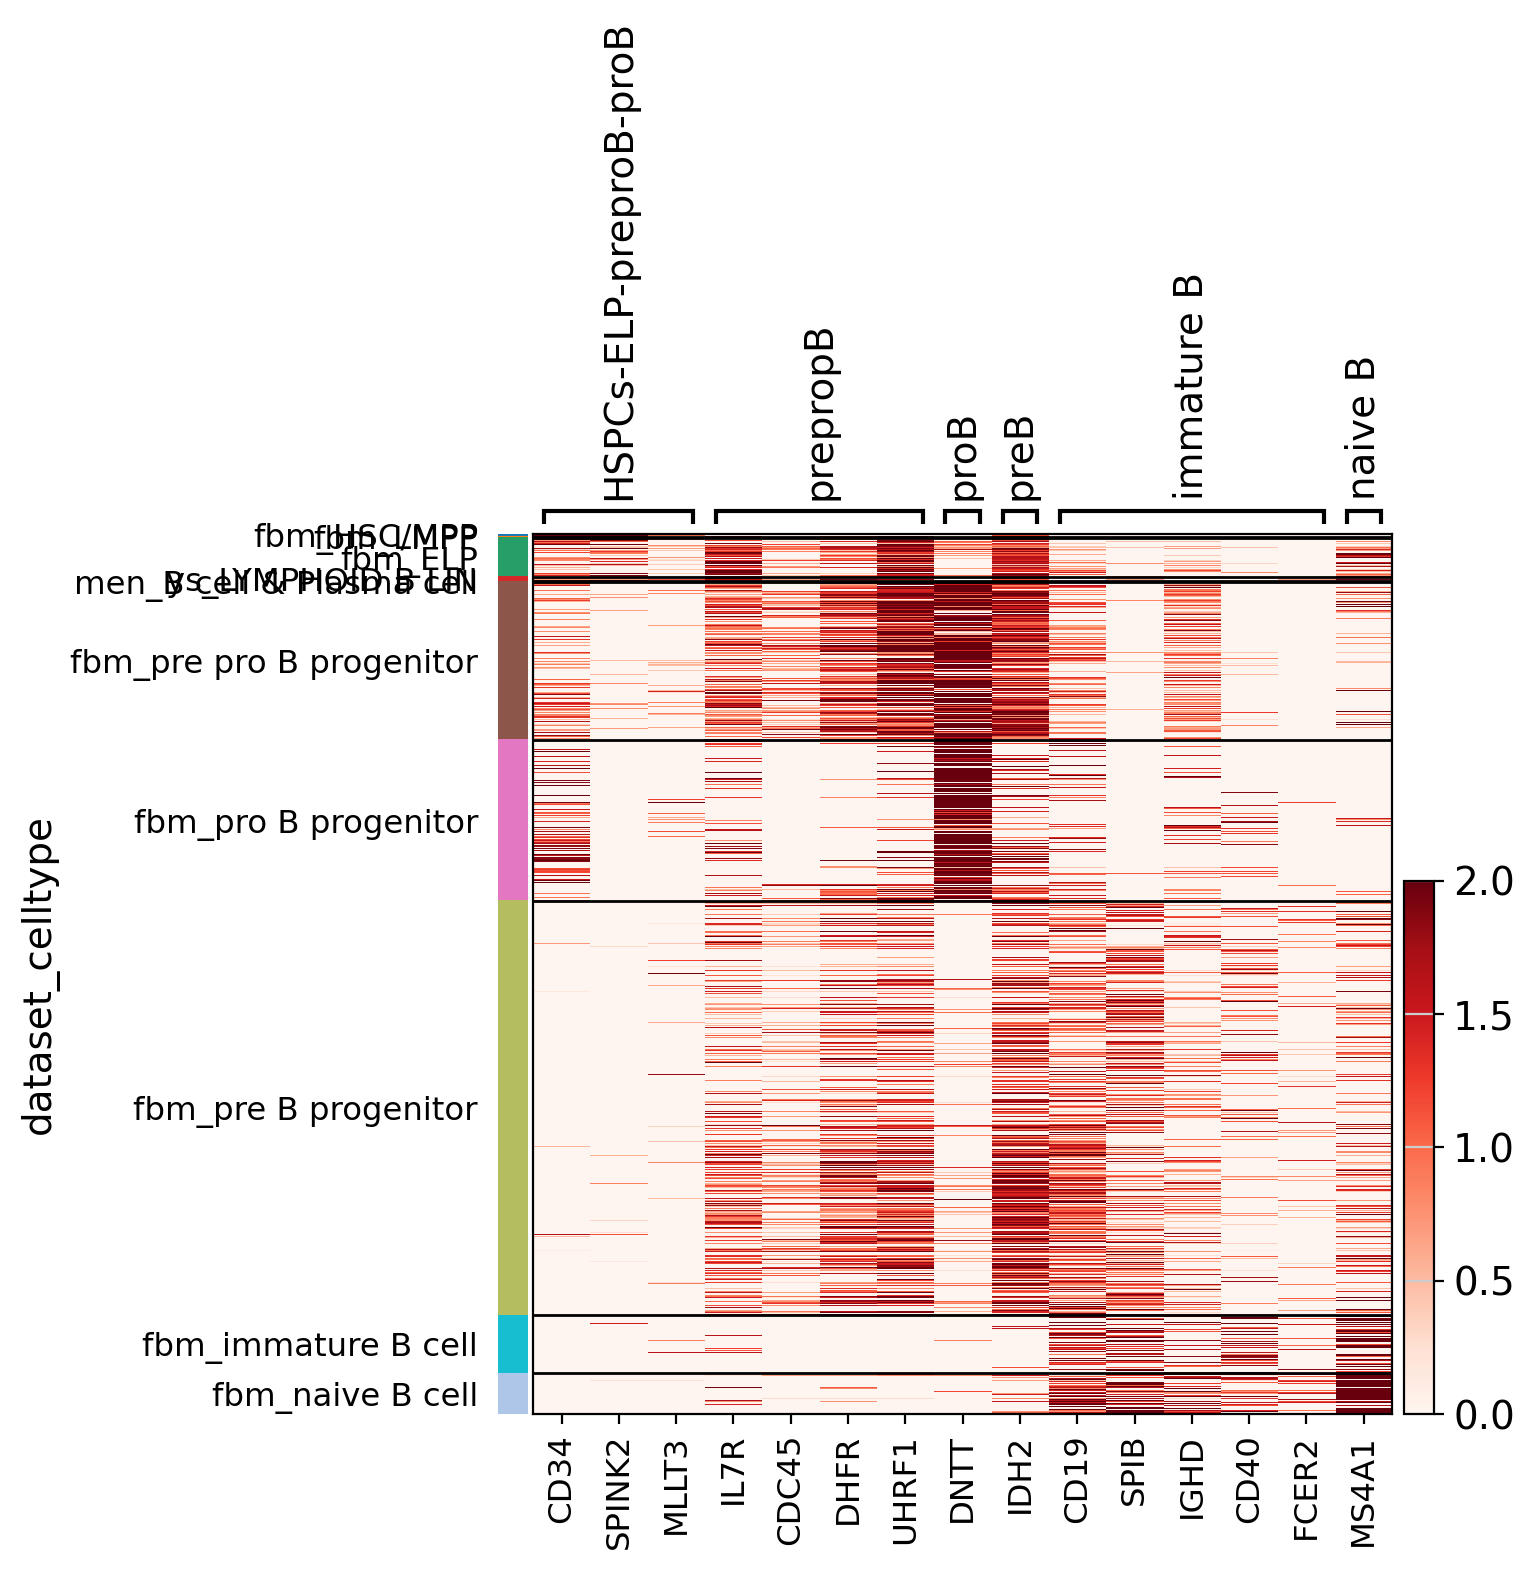

In [53]:
sc.settings.set_figure_params(dpi=100, dpi_save=1000)
sc.pl.heatmap(adata, var_names=gene_dict, save=f"_{heatmap_title}_{date}.pdf", 
              use_raw=False, swap_axes=False, figsize=(6,6), cmap ='Reds', vmax=vmax_setting, groupby=plotting_metadata_col)  

# 10 - Run dotplot

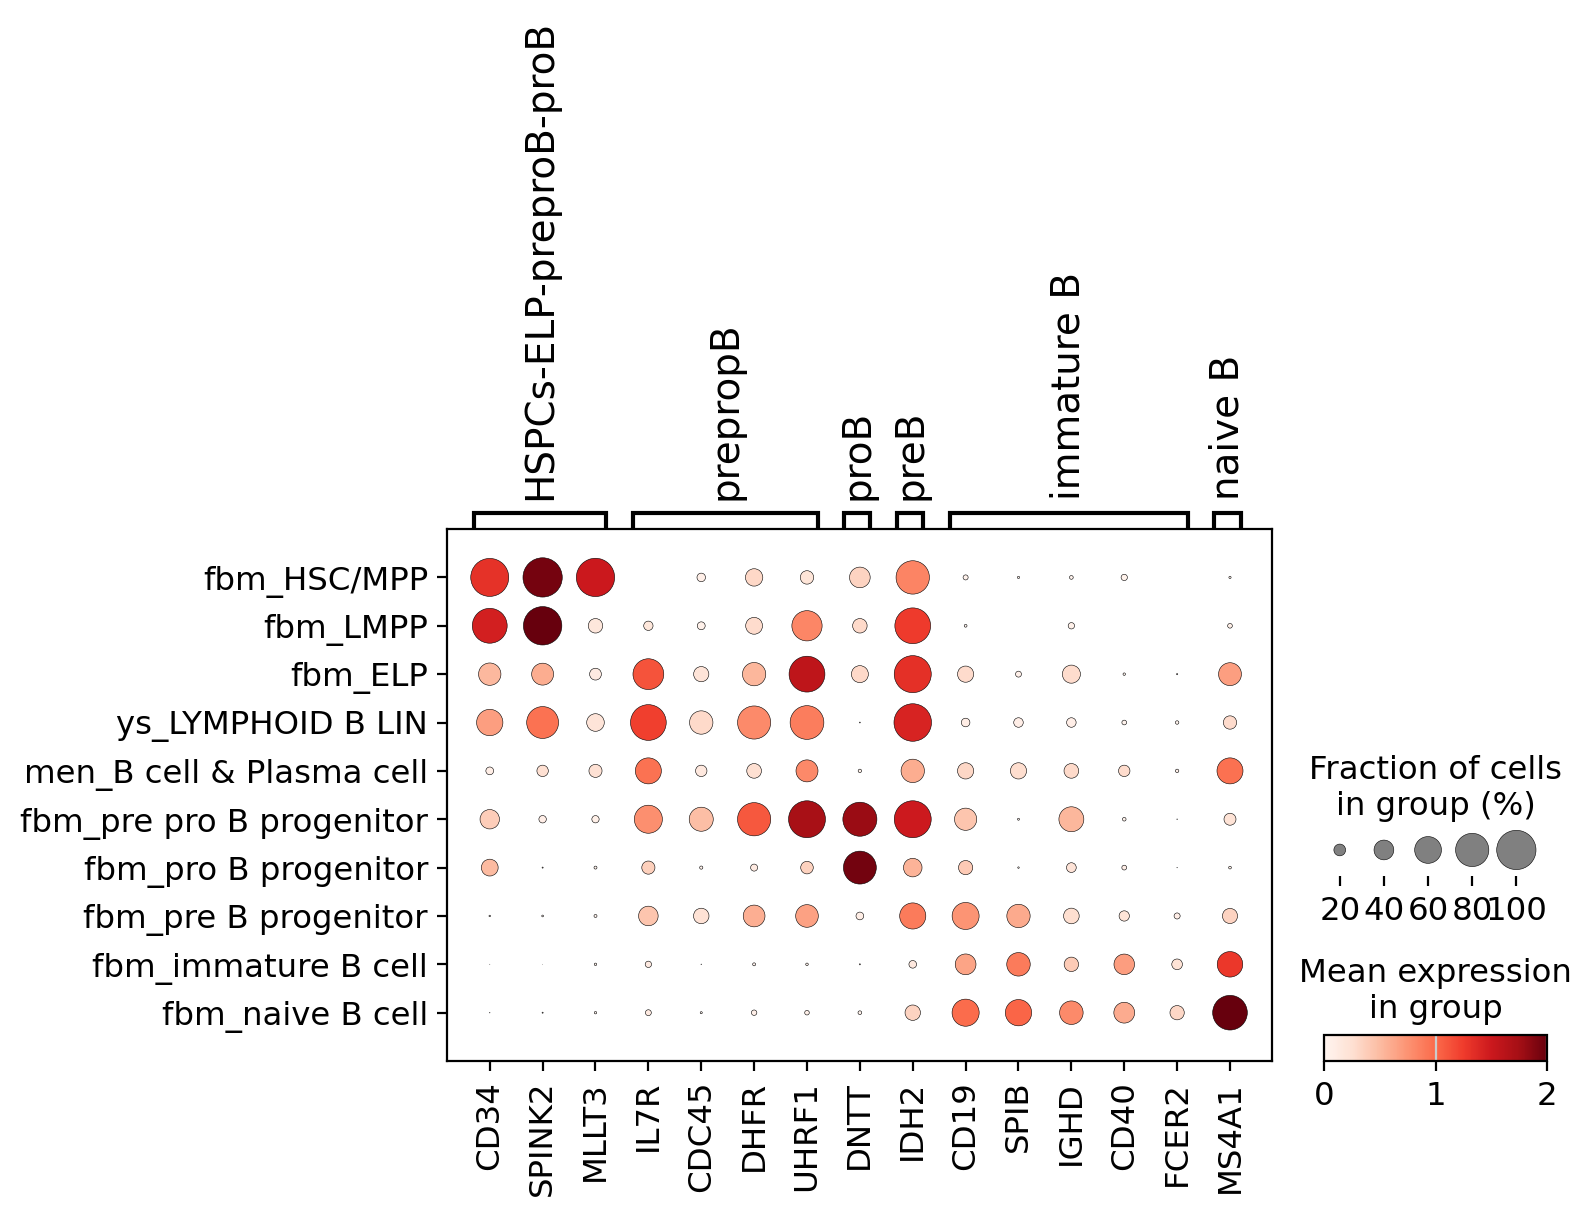

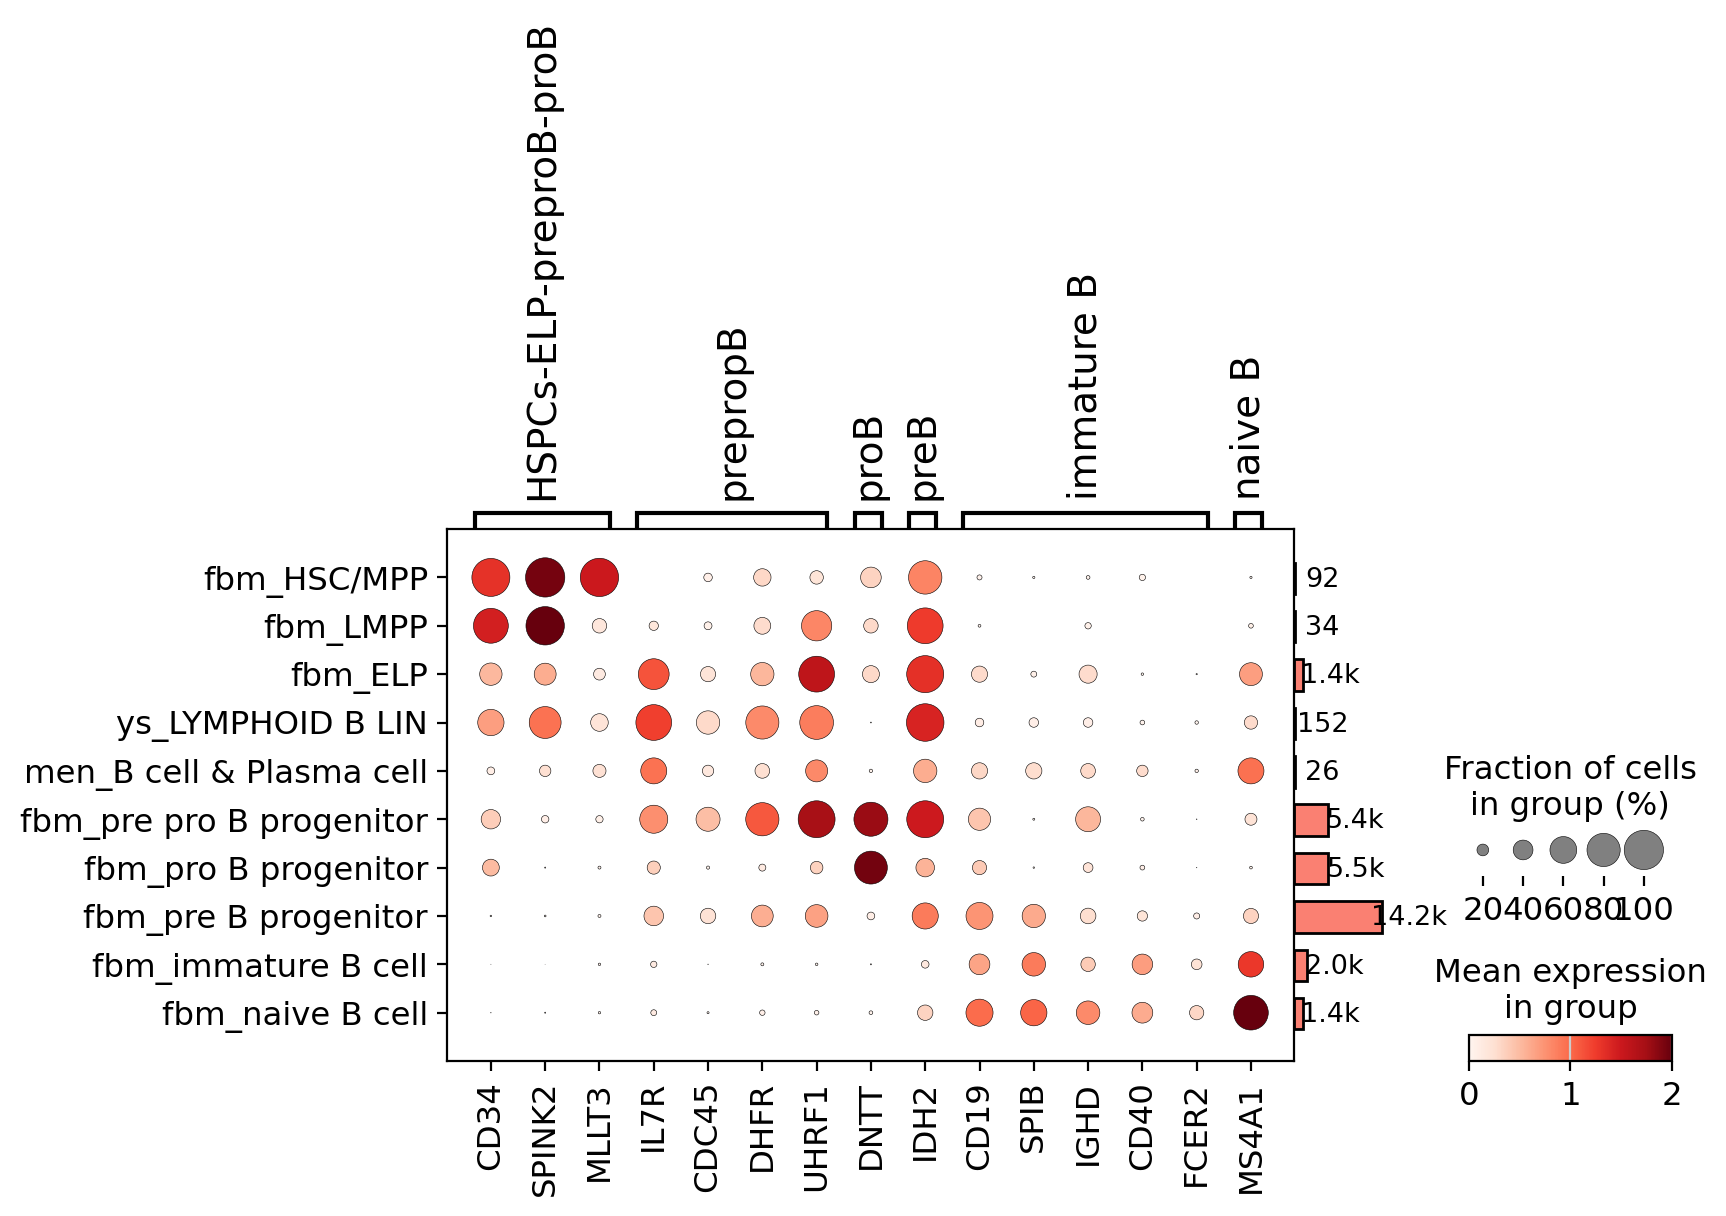

In [54]:
outputs_resources = '/lustre/scratch126/cellgen/team298/sw33/meninges/resources/dotplots/' # i will save excels, etc, here
outputs_figs = '/lustre/scratch126/cellgen/team298/sw33/meninges/figures/dotplots/' # i will save output figures here
dotplot_title=heatmap_title

sc.settings.set_figure_params(dpi=100, dpi_save=1000)
sc.pl.dotplot(adata, var_names=gene_dict, save=f"WE_{dotplot_title}_{date}.pdf",
              groupby=plotting_metadata_col, use_raw=False, vmax=vmax_setting)

dp = sc.pl.dotplot(adata, var_names=gene_dict, 
              groupby=plotting_metadata_col, use_raw=False, vmax=vmax_setting, return_fig=True)
dp.add_totals()
dp.savefig(outputs_figs + f"WE_{dotplot_title}_withpops_{date}.pdf")